In [3]:
#Importación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Cargar datasets
df_prob = pd.read_csv('../data/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')
df_master = pd.read_csv('../data/prueba_op_master_customer_data_enmascarado_completa.csv')
df_cuotas = pd.read_csv('../data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv')
df_test = pd.read_csv('../data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')

In [5]:
# Primeras filas y la info general de cada DataFrame
print("----- df_prob -----")
print(df_prob.info())
print(df_prob.head())

print("\n----- df_master -----")
print(df_master.info())
print(df_master.head())

print("\n----- df_cuotas -----")
print(df_cuotas.info())
print(df_cuotas.head())

----- df_prob -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804836 entries, 0 to 4804835
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   nit_enmascarado        int64  
 1   num_oblig_enmascarado  int64  
 2   fecha_corte            int64  
 3   lote                   int64  
 4   prob_propension        float64
 5   prob_alrt_temprana     float64
 6   prob_auto_cura         float64
dtypes: float64(3), int64(4)
memory usage: 256.6 MB
None
   nit_enmascarado  num_oblig_enmascarado  fecha_corte  lote  prob_propension  \
0           296482                 102381       202308     1         0.761350   
1           391957                 742315       202310     2         0.741803   
2           229894                 359919       202307     1         0.835373   
3           478963                 239064       202303     3         0.445002   
4           349609                 923348       202308     2         0.784365   



In [8]:
print("Valores nulos en df_prob:")
print(df_prob.isnull().sum())

print("Valores nulos en df_master:")
print(df_master.isnull().sum())

print("Valores nulos en df_cuotas:")
print(df_cuotas.isnull().sum())



Valores nulos en df_prob:
nit_enmascarado          0
num_oblig_enmascarado    0
fecha_corte              0
lote                     0
prob_propension          0
prob_alrt_temprana       7
prob_auto_cura           7
dtype: int64
Valores nulos en df_master:
nit_enmascarado               0
cod_tipo_doc                  0
tipo_cli                      0
ctrl_terc                     0
genero_cli                 7962
ano_nac_cli                7942
edad_cli                   7942
estado_civil              36474
tipo_vivienda            294877
num_hijos                  7942
personas_dependientes      7945
nivel_academico          245002
ocup                      23253
act_econom                31368
sector                    33268
subsector                 33268
declarante                  178
total_ing                     4
tot_activos                   4
tot_pasivos                   4
origen_fondos              5316
f_vinc                        0
f_ult_mantenimiento           0
canal_ac

Relación entre var_rpta_alt y tipo_cli
var_rpta_alt           0       1     All
tipo_cli                                
PERSONA JURíDICA    9396    2391   11787
PERSONA NATURAL   227686  216817  444503
All               237082  219208  456290


Relación entre var_rpta_alt y genero_cli
var_rpta_alt       0       1     All
genero_cli                          
F             108554  104360  212914
M             119124  112452  231576
All           227678  216812  444490


Relación entre var_rpta_alt y ctrl_terc
var_rpta_alt         0       1     All
ctrl_terc                             
CLIENTE         227903  214099  442002
CLIENTE SOCIAL    8409    4892   13301
CONYUGE              1       2       3
EXCLIENTE          744     212     956
NEQUI               21       2      23
PROSPECTO            4       1       5
All             237082  219208  456290


ano_nac_cli       float64
edad_cli          float64
total_ing         float64
tot_activos       float64
tot_pasivos       float64
egr

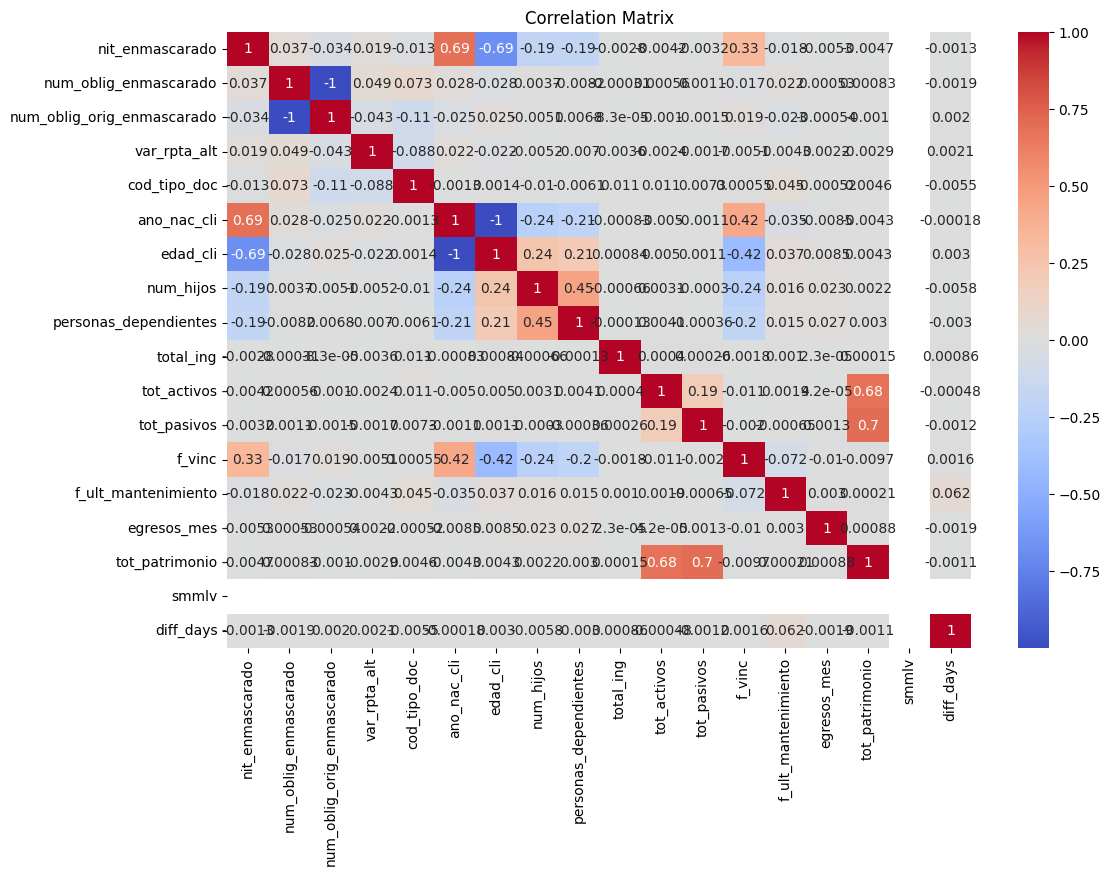

In [13]:
#Cruce con df_master
df_test = df_test[['nit_enmascarado', 'num_oblig_enmascarado', 'num_oblig_orig_enmascarado','var_rpta_alt','fecha_var_rpta_alt']]
df_master['fecha'] = pd.to_datetime(df_master[['year', 'month', 'ingestion_day']].rename(columns={'ingestion_day': 'day'}))

#Cruce de datos
dataset= pd.merge(df_test, df_master, on='nit_enmascarado',how='inner')

#Diferencia entre fecha_var_rpta_alt y la fecha en la master
dataset['fecha_var_rpta_alt'] = pd.to_datetime(dataset['fecha_var_rpta_alt'], format='%Y%m')
dataset['diff_days'] = (dataset['fecha_var_rpta_alt'] - dataset['fecha']).dt.days.abs()


# Eliminamos los duplicados, manteniendo el registro con la menor diferencia de días
dataset = dataset.drop_duplicates(subset=['nit_enmascarado','num_oblig_enmascarado','num_oblig_orig_enmascarado','fecha_var_rpta_alt'], keep='first')

dataset = dataset.drop(columns=['year', 'month', 'ingestion_day'])

# #Random imputation para genero de los clientes
# distribution = {'F': 0.52, 'M': 0.48}
# # Si hay algún otro valor, ajusta la distribución

# # Obtener el total de registros y los índices donde 'genero_cli' es nulo
# missing_idx = dataset['genero_cli'].isnull()

# # Número de valores faltantes
# num_missing = missing_idx.sum()
# # Generar asignaciones aleatorias basadas en la distribución
# imputed_values = np.random.choice(list(distribution.keys()), size=num_missing, p=list(distribution.values()))
# # Asignar los valores imputados
# dataset.loc[missing_idx, 'genero_cli'] = imputed_values

# ###########################################################
# #Imputar mediana a los clientes con edades menor a 18 y mayor a 100, y hijos con mayores a 10 hijos
# valid_edad = dataset.loc[(dataset['edad_cli'] >= 18) & (dataset['edad_cli'] <= 100), 'edad_cli']
# median_edad = valid_edad.median()

# # Reemplazar los valores fuera del rango [18, 100] con la mediana
# dataset.loc[(dataset['edad_cli'] < 18) | (dataset['edad_cli'] > 100), 'edad_cli'] = median_edad

# median_hijos = dataset['num_hijos'].median()
# dataset.loc[dataset['num_hijos'] > 10, 'num_hijos'] = median_hijos


# ###########################################################
# #Imputar ocupacion con KNN buscando vecinos con edad y segmento similar
# # Revisar cuántos valores nulos hay en la columna 'ocup'
# print("Valores nulos en 'ocup':", dataset['ocup'].isnull().sum())

# # Separar registros con ocupación conocida y con ocupación faltante
# df_known = dataset[dataset['ocup'].notnull()].copy()
# df_missing = dataset[dataset['ocup'].isnull()].copy()

# # Ajustar el LabelEncoder usando todas las categorías presentes en la columna 'segm' del dataset completo
# le_seg = LabelEncoder()
# le_seg.fit(dataset['segm'].astype(str))

# # Transformar la columna 'segm' en ambos subconjuntos
# df_known['segmento_enc'] = le_seg.transform(df_known['segm'].astype(str))
# df_missing['segmento_enc'] = le_seg.transform(df_missing['segm'].astype(str))

# # Seleccionar variables predictoras (usamos 'edad_cli' y 'segmento_enc'; puedes incluir 'total_ing' si lo consideras relevante)
# X_train = df_known[['edad_cli', 'segmento_enc']]
# y_train = df_known['ocup']

# X_missing = df_missing[['edad_cli', 'segmento_enc']]

# # Entrenar el modelo KNN (ajusta n_neighbors según convenga)
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)

# # Predecir la ocupación para los registros faltantes
# df_missing['ocup_imputed'] = knn.predict(X_missing)

# # Imprimir algunos resultados de la predicción
# print("Ejemplo de predicciones para ocupación faltante:")
# print(df_missing[['edad_cli', 'segm', 'ocup_imputed']].head())

# # Actualizar la columna 'ocup' en el DataFrame original (dataset) con los valores imputados
# dataset.loc[dataset['ocup'].isnull(), 'ocup'] = df_missing['ocup_imputed']

# # Verificar que ya no queden valores nulos en 'ocup'
# print("Valores nulos en 'ocup' después de imputar:", dataset['ocup'].isnull().sum())



#Crosstabs para ver la distribución de var_rpta_alt
categorical_vars = ['tipo_cli', 'genero_cli','ctrl_terc']
for var in categorical_vars:
    table = pd.crosstab(dataset[var], dataset['var_rpta_alt'], margins=True)
    print(f"Relación entre var_rpta_alt y {var}")
    print(table)
    print("\n")

    # Convertir los campos a tipos de datos numéricos
fields_to_convert = ['ano_nac_cli', 'edad_cli', 'total_ing', 'tot_activos', 'tot_pasivos', 'egresos_mes', 'tot_patrimonio']
dataset[fields_to_convert] = dataset[fields_to_convert].apply(pd.to_numeric, errors='coerce')

# Verificar la conversión
print(dataset[fields_to_convert].dtypes)

# Calcular la correlación para variables numéricas
correlation_matrix = dataset.corr(numeric_only=True)
print(correlation_matrix['var_rpta_alt'].sort_values(ascending=False))

# Graficar la correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

